Una de las principales tareas que se pretende lograr en la IA conversacional es la generación de lenguaje natural (NLG), que se refiere al empleo de modelos para la generación de lenguaje natural. En este artículo, pondremos nuestras manos en NLG mediante la construcción de un generador de poesía basado en LSTM

El conjunto de datos utilizado para construir el modelo se obtuvo de Kaggle. El conjunto de datos es una recopilación de poesías escritas por numerosos poetas presentes en forma de archivo de texto. Podemos utilizar fácilmente estos datos para generar incrustaciones y, posteriormente, entrenar un modelo LSTM. Puede encontrar el conjunto de datos aquí 

**Construyendo el Generador de Texto**

El generador de texto se puede construir en los siguientes pasos simples:

**Paso 1. Importar bibliotecas necesarias**

En primer lugar, necesitamos importar las bibliotecas necesarias. Vamos a usar TensorFlow con Keras para construir el LSTM bidireccional. 

En caso de que alguna de las bibliotecas mencionadas no esté instalada, simplemente instálela con el comando pip install [nombre del paquete] en la terminal.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


**Paso 2. Carga del conjunto de datos y análisis de datos exploratorios**

Ahora, cargaremos nuestro conjunto de datos usando pandas. Además, necesitamos realizar un análisis exploratorio de datos para conocer mejor nuestros datos. Como estamos tratando con datos de texto, la mejor manera de hacerlo es generando una nube de palabras.

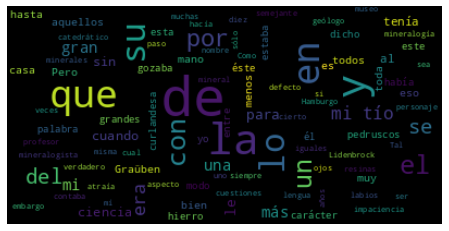

In [12]:
# Reading the text data file
data = open('cuento.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()


**Paso 3. Creando el Corpus**

Ahora, tenemos todos nuestros datos presentes en este archivo de texto masivo. Sin embargo, no se recomienda alimentar nuestro modelo con todos los datos juntos, ya que conduciría a una menor precisión. Por lo tanto, dividiremos nuestro texto en líneas para que podamos usarlas para generar incrustaciones de texto para nuestro modelo.

In [13]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])


['mi tío no gozaba, por desgracia, de una gran facilidad de palabra, por lo menos cuando', 'se expresaba en público, lo cual, para un orador, constituye un defecto lamentable. en sus', 'explicaciones en el johannaeum, se detenía a lo mejor luchando con un recalcitrance', 'vocablo que no quería salir do sus labios; con una de esas palabras que se resisten, se', 'hinchan y acaban por ser expelidas bajo la forma de un taco, siendo éste el origen de su', 'cólera.', 'hay en mineralogía muchas denominaciones, semigriegas, semilatinas, difíciles de', 'pronunciar; nombres rudos que desollarían los labios de un poeta. no quiero hablar oral', 'de esta ciencia; lejos de mí profanación semejante. pero cuando se trata de las', 'cristalizaciones romboédricas, de las resinas retinasfálticas, de las selenitas, de las']


**Paso 4. Colocando el Tokenizer en el Corpus**

Para poder generar las incrustaciones más tarde, necesitamos colocar un Tokenizer de TensorFlow en todo el corpus para que aprenda el vocabulario.  

In [14]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 662


**Paso 5. Generación de incrustaciones/vectorización**

Ahora generaremos incrustaciones para cada oración en nuestro corpus. Las incrustaciones son representaciones vectorizadas de nuestro texto. Dado que no podemos alimentar modelos de Machine/Deep Learning con texto no estructurado, este es un paso imperativo. En primer lugar, convertimos cada oración en incrustación usando la función text_to_sequence() de Keras. Luego calculamos la longitud de la incrustación más larga; finalmente, rellenamos con ceros todas las incrustaciones a esa longitud máxima para asegurar incrustaciones de igual longitud.

In [15]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


**Paso 6. Construcción del modelo LSTM bidireccional **

A estas alturas, hemos terminado con todos los pasos de preprocesamiento que se requerían para alimentar el texto a nuestro modelo. Ahora es el momento de que empecemos a construir el modelo. Dado que este es un caso de uso de generación de texto, crearemos un modelo LSTM bidireccional, ya que el significado juega un papel importante aquí. 

In [16]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100,
					input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18, 100)           66300     
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 300)          301200    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 18, 300)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 662)               66862     
                                                                 
 dense_3 (Dense)             (None, 663)               439569    
                                                      

El modelo funcionará con un enfoque basado en la predicción de la siguiente palabra en el que ingresaremos un texto inicial y el modelo generará poesía al predecir las palabras posteriores. Es por eso que hemos utilizado una función de activación softmax que generalmente se usa para casos de uso de clasificación de clases múltiples. 

**Paso 7. Entrenamiento modelo**

Habiendo construido la arquitectura del modelo, ahora la entrenaremos en nuestro texto preprocesado. Aquí, hemos entrenado nuestro modelo durante 150 épocas.

In [17]:
history = model.fit(predictors, label, epochs=150, verbose=1)


Epoch 1/150
41/41 [==============================] - 12s 142ms/step - loss: 7.1190 - accuracy: 0.0511
Epoch 2/150
41/41 [==============================] - 3s 77ms/step - loss: 6.0538 - accuracy: 0.0763
Epoch 3/150
41/41 [==============================] - 1s 30ms/step - loss: 5.7760 - accuracy: 0.0763
Epoch 4/150
41/41 [==============================] - 1s 18ms/step - loss: 5.4807 - accuracy: 0.0763
Epoch 5/150
41/41 [==============================] - 1s 22ms/step - loss: 5.2490 - accuracy: 0.0763
Epoch 6/150
41/41 [==============================] - 1s 17ms/step - loss: 5.1474 - accuracy: 0.0725
Epoch 7/150
41/41 [==============================] - 1s 21ms/step - loss: 5.0733 - accuracy: 0.0733
Epoch 8/150
41/41 [==============================] - 1s 13ms/step - loss: 5.0002 - accuracy: 0.0802
Epoch 9/150
41/41 [==============================] - 0s 9ms/step - loss: 4.9155 - accuracy: 0.0679
Epoch 10/150
41/41 [==============================] - 0s 9ms/step - loss: 4.8480 - accuracy: 0.0802

**Paso 8. Generación de texto usando el modelo construido**

En el paso final, generaremos poesía usando nuestro modelo. Como se indicó anteriormente, el modelo se basa en un enfoque de predicción de la siguiente palabra; por lo tanto, debemos proporcionarle al modelo algún texto inicial.

In [18]:
seed_text = "El mundo"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)


El mundo de la casita de un orador constituye un defecto lamentable en sus horas volvíamos en el martillo el suerte de aquellos insensibles minerales que eso
